<a href="https://colab.research.google.com/github/Sopralapanca/CommonLitChallenge/blob/main/Correction%2BPOS%2BNER%2BPrepareDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data importing and setup

In [ ]:
!pip install spacy pyspellchecker symspellpy swifter

In [ ]:
 !pip install --no-cache-dir transformers

In [ ]:
!python -m spacy download en_core_web_sm

2023-10-01 16:46:30.070366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 16:46:31.880953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-01 16:46:34.400147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-01 16:46:34.400720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [ ]:
!git clone "https://github.com/Sopralapanca/CommonLitChallenge.git"

fatal: destination path 'CommonLitChallenge' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import swifter
import numpy as np
summaries_train_path = "/content/CommonLitChallenge/data/summaries_train.csv"
prompt_train_path = "/content/CommonLitChallenge/data/prompts_train.csv"

train_data = pd.read_csv(summaries_train_path, sep=',', index_col=0)
prompt_data = pd.read_csv(prompt_train_path, sep=',', index_col=0)

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

train_data['tokenized_text'] = train_data.swifter.apply(lambda x: tokenizer.tokenize(x.text), axis=1)
train_data['tokenized_text_len'] = train_data.swifter.apply(lambda x: len(x.tokenized_text), axis=1)
train_data.drop(columns=['tokenized_text'], inplace=True)

prompt_data['tokenized_prompt_text'] = prompt_data.swifter.apply(lambda x: tokenizer.tokenize(x.prompt_text), axis=1)
prompt_data['tokenized_prompt_text_len'] = prompt_data.swifter.apply(lambda x: len(x.tokenized_prompt_text), axis=1)
prompt_data.drop(columns=['tokenized_prompt_text'], inplace=True)

prompt_data['tokenized_prompt_title'] = prompt_data.swifter.apply(lambda x: tokenizer.tokenize(x.prompt_title), axis=1)
prompt_data['tokenized_prompt_title_len'] = prompt_data.swifter.apply(lambda x: len(x.tokenized_prompt_title), axis=1)
prompt_data.drop(columns=['tokenized_prompt_title'], inplace=True)

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
print(train_data['tokenized_text_len'].describe())
print(prompt_data['tokenized_prompt_text_len'].describe())
print(prompt_data['tokenized_prompt_title_len'].describe())

count    7165.000000
mean       93.229170
std        68.764623
min        26.000000
25%        48.000000
50%        71.000000
75%       114.000000
max       865.000000
Name: tokenized_text_len, dtype: float64
count       4.000000
mean      842.250000
std       244.349988
min       675.000000
25%       698.250000
50%       746.000000
75%       890.000000
max      1202.000000
Name: tokenized_prompt_text_len, dtype: float64
count    4.000000
mean     4.000000
std      1.414214
min      3.000000
25%      3.000000
50%      3.500000
75%      4.500000
max      6.000000
Name: tokenized_prompt_title_len, dtype: float64


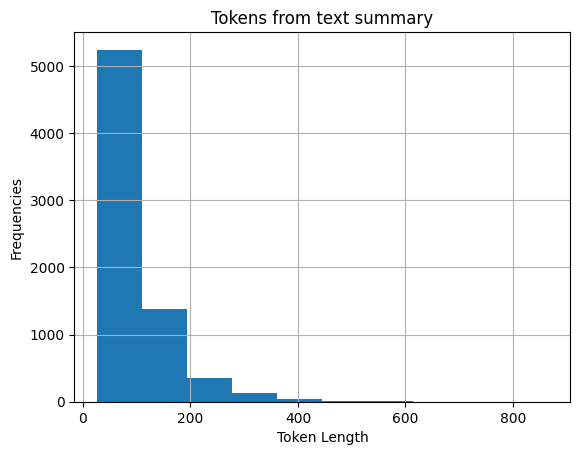

In [ ]:
import matplotlib.pyplot as plt

axarr = train_data['tokenized_text_len'].hist()
axarr.set_xlabel('Token Length')
axarr.set_ylabel('Frequencies')
axarr.set_title('Tokens from text summary')
plt.show()

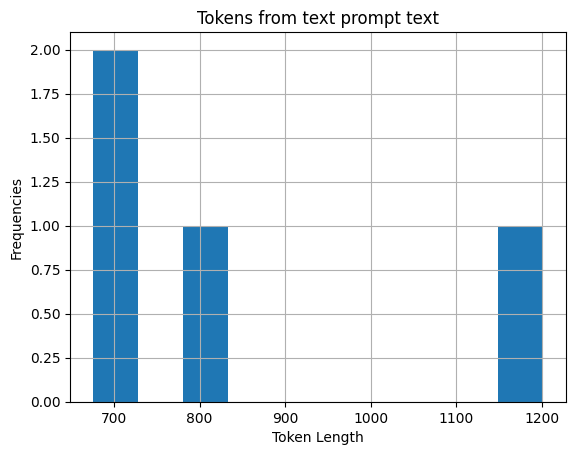

In [ ]:
axarr = prompt_data['tokenized_prompt_text_len'].hist()
axarr.set_xlabel('Token Length')
axarr.set_ylabel('Frequencies')
axarr.set_title('Tokens from text prompt text')
plt.show()

In [ ]:
prompt_data.drop(columns=['tokenized_prompt_text_len'], inplace=True)
prompt_data.drop(columns=['tokenized_prompt_title_len'], inplace=True)
train_data.drop(columns=['tokenized_text_len'], inplace=True)

### Spacy and SymSpell Magic Class

> Definition of the Glossary \\
> Creation of the word list \\
> Language Model Class construction

In [ ]:
# @title Glossary def.
POS_GLOSSARY = {
    # POS tags
    # Universal POS Tags
    # http://universaldependencies.org/u/pos/
    "ADJ": "adjective",
    "ADP": "adposition",
    "ADV": "adverb",
    "AUX": "auxiliary",
    "CONJ": "conjunction",
    "CCONJ": "coordinating conjunction",
    "DET": "determiner",
    "INTJ": "interjection",
    "NOUN": "noun",
    "NUM": "numeral",
    "PART": "particle",
    "PRON": "pronoun",
    "PROPN": "proper noun",
    "PUNCT": "punctuation",
    "SCONJ": "subordinating conjunction",
    "SYM": "symbol",
    "VERB": "verb",
    "X": "other",
    "EOL": "end of line",
    "SPACE": "space",
    # POS tags (English)
    # OntoNotes 5 / Penn Treebank
    # https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    ".": "punctuation mark, sentence closer",
    ",": "punctuation mark, comma",
    "-LRB-": "left round bracket",
    "-RRB-": "right round bracket",
    "``": "opening quotation mark",
    '""': "closing quotation mark",
    "''": "closing quotation mark",
    ":": "punctuation mark, colon or ellipsis",
    "$": "symbol, currency",
    "#": "symbol, number sign",
    "AFX": "affix",
    "CC": "conjunction, coordinating",
    "CD": "cardinal number",
    "DT": "determiner",
    "EX": "existential there",
    "FW": "foreign word",
    "HYPH": "punctuation mark, hyphen",
    "IN": "conjunction, subordinating or preposition",
    "JJ": "adjective (English), other noun-modifier (Chinese)",
    "JJR": "adjective, comparative",
    "JJS": "adjective, superlative",
    "LS": "list item marker",
    "MD": "verb, modal auxiliary",
    "NIL": "missing tag",
    "NN": "noun, singular or mass",
    "NNP": "noun, proper singular",
    "NNPS": "noun, proper plural",
    "NNS": "noun, plural",
    "PDT": "predeterminer",
    "POS": "possessive ending",
    "PRP": "pronoun, personal",
    "PRP$": "pronoun, possessive",
    "RB": "adverb",
    "RBR": "adverb, comparative",
    "RBS": "adverb, superlative",
    "RP": "adverb, particle",
    "TO": 'infinitival "to"',
    "UH": "interjection",
    "VB": "verb, base form",
    "VBD": "verb, past tense",
    "VBG": "verb, gerund or present participle",
    "VBN": "verb, past participle",
    "VBP": "verb, non-3rd person singular present",
    "VBZ": "verb, 3rd person singular present",
    "WDT": "wh-determiner",
    "WP": "wh-pronoun, personal",
    "WP$": "wh-pronoun, possessive",
    "WRB": "wh-adverb",
    "SP": "space (English), sentence-final particle (Chinese)",
    "ADD": "email",
    "NFP": "superfluous punctuation",
    "GW": "additional word in multi-word expression",
    "XX": "unknown",
    "BES": 'auxiliary "be"',
    "HVS": 'forms of "have"',
    "_SP": "whitespace",
    # Dependency Labels (English)
    # ClearNLP / Universal Dependencies
    # https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md
    "acl": "clausal modifier of noun (adjectival clause)",
    "acomp": "adjectival complement",
    "advcl": "adverbial clause modifier",
    "advmod": "adverbial modifier",
    "agent": "agent",
    "amod": "adjectival modifier",
    "appos": "appositional modifier",
    "attr": "attribute",
    "aux": "auxiliary",
    "auxpass": "auxiliary (passive)",
    "case": "case marking",
    "cc": "coordinating conjunction",
    "ccomp": "clausal complement",
    "clf": "classifier",
    "complm": "complementizer",
    "compound": "compound",
    "conj": "conjunct",
    "cop": "copula",
    "csubj": "clausal subject",
    "csubjpass": "clausal subject (passive)",
    "dative": "dative",
    "dep": "unclassified dependent",
    "det": "determiner",
    "discourse": "discourse element",
    "dislocated": "dislocated elements",
    "dobj": "direct object",
    "expl": "expletive",
    "fixed": "fixed multiword expression",
    "flat": "flat multiword expression",
    "goeswith": "goes with",
    "hmod": "modifier in hyphenation",
    "hyph": "hyphen",
    "infmod": "infinitival modifier",
    "intj": "interjection",
    "iobj": "indirect object",
    "list": "list",
    "mark": "marker",
    "meta": "meta modifier",
    "neg": "negation modifier",
    "nmod": "modifier of nominal",
    "nn": "noun compound modifier",
    "npadvmod": "noun phrase as adverbial modifier",
    "nsubj": "nominal subject",
    "nsubjpass": "nominal subject (passive)",
    "nounmod": "modifier of nominal",
    "npmod": "noun phrase as adverbial modifier",
    "num": "number modifier",
    "number": "number compound modifier",
    "nummod": "numeric modifier",
    "oprd": "object predicate",
    "obj": "object",
    "obl": "oblique nominal",
    "orphan": "orphan",
    "parataxis": "parataxis",
    "partmod": "participal modifier",
    "pcomp": "complement of preposition",
    "pobj": "object of preposition",
    "poss": "possession modifier",
    "possessive": "possessive modifier",
    "preconj": "pre-correlative conjunction",
    "prep": "prepositional modifier",
    "prt": "particle",
    "punct": "punctuation",
    "quantmod": "modifier of quantifier",
    "rcmod": "relative clause modifier",
    "relcl": "relative clause modifier",
    "reparandum": "overridden disfluency",
    "root": "root",
    "ROOT": "root",
    "vocative": "vocative",
    "xcomp": "open clausal complement",
}
NER_GLOSSARY = {
    # Named Entity Recognition
    # OntoNotes 5
    # https://catalog.ldc.upenn.edu/docs/LDC2013T19/OntoNotes-Release-5.0.pdf
    "PERSON": "People, including fictional",
    "NORP": "Nationalities or religious or political groups",
    "FACILITY": "Buildings, airports, highways, bridges, etc.",
    "FAC": "Buildings, airports, highways, bridges, etc.",
    "ORG": "Companies, agencies, institutions, etc.",
    "GPE": "Countries, cities, states",
    "LOC": "Non-GPE locations, mountain ranges, bodies of water",
    "PRODUCT": "Objects, vehicles, foods, etc. (not services)",
    "EVENT": "Named hurricanes, battles, wars, sports events, etc.",
    "WORK_OF_ART": "Titles of books, songs, etc.",
    "LAW": "Named documents made into laws.",
    "LANGUAGE": "Any named language",
    "DATE": "Absolute or relative dates or periods",
    "TIME": "Times smaller than a day",
    "PERCENT": 'Percentage, including "%"',
    "MONEY": "Monetary values, including unit",
    "QUANTITY": "Measurements, as of weight or distance",
    "ORDINAL": '"first", "second", etc.',
    "CARDINAL": "Numerals that do not fall under another type",
    # Named Entity Recognition
    # Wikipedia
    # http://www.sciencedirect.com/science/article/pii/S0004370212000276
    # https://pdfs.semanticscholar.org/5744/578cc243d92287f47448870bb426c66cc941.pdf
    "PER": "Named person or family.",
    "MISC": "Miscellaneous entities, e.g. events, nationalities, products or works of art",
    # https://github.com/ltgoslo/norne
    "EVT": "Festivals, cultural events, sports events, weather phenomena, wars, etc.",
    "PROD": "Product, i.e. artificially produced entities including speeches, radio shows, programming languages, contracts, laws and ideas",
    "DRV": "Words (and phrases?) that are dervied from a name, but not a name in themselves, e.g. 'Oslo-mannen' ('the man from Oslo')",
    "GPE_LOC": "Geo-political entity, with a locative sense, e.g. 'John lives in Spain'",
    "GPE_ORG": "Geo-political entity, with an organisation sense, e.g. 'Spain declined to meet with Belgium'",
}

#### Creating the list of words

In [ ]:
import itertools
word_list = []
for prompt, query, title in zip(prompt_data.prompt_text.tolist(), prompt_data.prompt_question.tolist(), prompt_data.prompt_title.tolist()):
  word_list.append(prompt.replace('\n', ' ').split())
  word_list.append(query.replace('\n', ' ').split())
  word_list.append(title.replace('\n', ' ').split())
token_list = list(itertools.chain(*word_list))

#### Construction of the Class


In [ ]:
from symspellpy import SymSpell
import pkg_resources
import spacy

class LanguageMagician():
  def __init__(self, words) -> None:
    # Initialization of Spacy
    self.nlp = spacy.load("en_core_web_sm")

    # Initialization of SymSpell
    self.sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt"
    )
    bigram_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
    )
    # term_index is the column of the term and count_index
    # is the column of the term frequency
    self.sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    self.sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
    # Spacy vocabulary initialization
    vector_data = {word: np.random.uniform(-1, 1, (300,)) for word in words}
    vocab = self.nlp.vocab
    for word, vector in vector_data.items():
        vocab.set_vector(word, vector)

    # SymSpell vocabulary initialization
    text_file = open("vocabulary.txt", "a")
    for s in words:
      text_file.write(s)
    text_file.close()
    corpus_path = 'vocabulary.txt'
    try:
      result = self.sym_spell.create_dictionary(corpus_path)
    except:
      raise(f'error the dictionary creation has returned {result}')

  def correct(self, row):
    # max edit distance per lookup (per single word, not per whole input string)
    try:
      suggestions = self.sym_spell.lookup_compound(row, max_edit_distance=2, transfer_casing=True)
      return suggestions[0].term, suggestions[0].distance
    except:
      suggestions = self.sym_spell.lookup_compound(row, max_edit_distance=2, transfer_casing=False)
      return suggestions[0].term, suggestions[0].distance

  def pos_scorer(self, row):
    pos_vector = dict.fromkeys(POS_GLOSSARY.keys(), 0)
    doc = self.nlp(row)
    for d in doc:
      pos_vector[d.pos_] += 1
    single_pos_score = 0
    np_pos = np.asarray(list(pos_vector.values()))
    for i, pos in enumerate(np_pos):
      single_pos_score += int(pos)
    return single_pos_score

  def entity_scorer(self, row):
    doc = self.nlp(row)
    ents = [(e.text, e.label_) for e in doc.ents]
    entity_vector = dict.fromkeys(NER_GLOSSARY.keys(), 0)
    for ent in ents:
      entity_vector[ent[1]] += 1
    single_ent_score = 0
    np_ent = np.asarray(list(entity_vector.values()))
    for i, ent in enumerate(np_ent):
      single_ent_score += int(ent)
    return single_ent_score

  # def semantic_similarity(self, text1, text2):
  #   embedding1 = self.nlp(text1)
  #   embedding2 = self.nlp(text2)
  #   return embedding1.similarity(embedding2)

lang_wizard = LanguageMagician(token_list)

### Text processing

In [ ]:
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocessText(text, removal=True):
    # replace newline with space
    text = text.replace("\n", " ")
    text = text.replace('\r', ' ')

    # Normalize spaces around punctuation marks
    text = re.sub(r"[^A-Za-z0-9']", r' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Replace curly apostrophe with straight single quote
    text = text.replace('’', "'")

    # Normalize spaces around punctuation marks
    text = text.strip()

    # lower case
    text = text.lower()

    if removal:
      # split text
      words = text.split()

      # stop word removal
      words = [w for w in words if not w in stop_words]

      # stemming
      # words = [stemmer.stem(w) for w in words]

      # lemmatization
      words = [lemmatizer.lemmatize(w) for w in words]

      text = ' '.join(words)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### StopWords Count

In [ ]:
# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stop_words)
    return stopwords_count

### Punctuation Count

In [ ]:
# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

### Different Words counter

In [ ]:
def different_word_counter(row):
  row = preprocessText(row)
  words_list = []
  for w in row.split(' '):
    if w not in words_list:
      words_list.append(w)

  return len(words_list)

### Words counter

In [ ]:
def count_words(text):
    return len(text.split(' '))

### N-grams finding

In [ ]:
from nltk.util import ngrams
from collections import Counter
import nltk
nltk.download('punkt')  # Download the required resources for tokenization

def count_ngrams(text, n):
  words = nltk.word_tokenize(text)
  ngram_counts = Counter(ngrams(words, n))
  return ngram_counts

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Dataset Application before merging


In [ ]:
del_columns = []
# Correct the text
train_data[["corrected_text", "distance"]] = train_data.swifter.apply(lambda x: lang_wizard.correct(x.text), axis=1, result_type='expand')
# Preprocess the text
prompt_data["prompt_preprocessed"] = prompt_data["prompt_text"].swifter.apply(lambda x: preprocessText(x))
train_data["text_preprocessed"] =    train_data["corrected_text"].swifter.apply(lambda x: preprocessText(x))
# Count the length of text
prompt_data["prompt_length"] = prompt_data["prompt_text"].swifter.apply(len)
train_data["text_length"] =    train_data["corrected_text"].swifter.apply(len)
del_columns.append("prompt_length")
# N-Grams counting
for n in range(2,5):
  prompt_data[f"{n}grams_prompt_cnt"] = prompt_data.swifter.apply(lambda row: count_ngrams(row["prompt_text"], n), axis=1)
  del_columns.append(f"{n}grams_prompt_cnt")

  train_data[f"{n}grams_corrected_cnt"] = train_data.swifter.apply(lambda row: count_ngrams(row["corrected_text"], n), axis=1)
  del_columns.append(f"{n}grams_corrected_cnt")

  train_data[f"{n}grams_text_cnt"] = train_data.swifter.apply(lambda row: count_ngrams(row["text"], n), axis=1)
  del_columns.append(f"{n}grams_text_cnt")
# POS vectorization
train_data['text_pos'] = train_data['corrected_text'].swifter.apply(lambda row: lang_wizard.pos_scorer(row))
# Entity vectorization
train_data['entities'] = train_data['corrected_text'].swifter.apply(lambda row: lang_wizard.entity_scorer(row))
# Different Word Counter
prompt_data["prompt_different_word_cnt"] = prompt_data['prompt_text'].swifter.apply(lambda row: different_word_counter(row))
train_data['text_different_word_cnt'] = train_data['corrected_text'].swifter.apply(lambda row: different_word_counter(row))
del_columns.append("prompt_different_word_cnt")

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

In [ ]:
# @title Merging the dataset
training_data = train_data.merge(prompt_data, on='prompt_id')

### Different words counter ratio

In [ ]:
def word_counter_ratio(summary_word_counter, prompt_word_counter):
  return summary_word_counter/prompt_word_counter

### N-grams counting

In [ ]:
def count_cooccurring_ngrams(text, prompt_text):
    cooccurring_count = sum((text & prompt_text).values())
    return cooccurring_count

### Misspelling finding and counting

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()
spell.word_frequency.load_words(token_list)

def misspelled(text):
  words = text.split()
  misspelled = spell.unknown(words)
  return misspelled

### TF-IDF score creation

In [ ]:
def add_row(df1, df2, preprocess=False):
  row = df2.unique().tolist()[0]
  if preprocess:
    row = preprocessText(row)
  combined_data = pd.concat([pd.Series([row]),df1.loc[:]]).reset_index(drop=True) #append row on the head of the dataframe
  return combined_data

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Group by 'prompt_id' and compute TF-IDF separately for each class
tfidf_vectorizers = {}

for class_id, group in training_data.groupby('prompt_id'):
    text_data = group['text_preprocessed']
    prompt_question_data = group['prompt_question']
    prompt_title_data = group['prompt_title']
    prompt_text_data = group['prompt_preprocessed']

    # Concatenate the preprocessed data for TF-IDF calculation
    combined_data = add_row(text_data, prompt_question_data, True)
    combined_data = add_row(combined_data, prompt_title_data, True)
    combined_data = add_row(combined_data, prompt_text_data)

    # Compute TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_data)
    tfidf_vectorizers[class_id] = {'vectorizer': tfidf_vectorizer, 'matrix': tfidf_matrix}

In [ ]:
karp_tfidf_scores = {}

# Calculate TF-IDF scores for each document
for class_id, group in training_data.groupby('prompt_id'):
    tfidf_vectorizer = tfidf_vectorizers[class_id]['vectorizer']
    tfidf_matrix = tfidf_vectorizers[class_id]['matrix']
    tfidf_matrix = tfidf_matrix[3:] #remove first 3 rows f the matrix since they belongs to prompt_text, prompt_question, prompt_title


    # Iterate through documents and calculate TF-IDF scores
    for index, row in group.iterrows():
        doc_tfidf = tfidf_matrix[index - group.index[0]].toarray()[0]

        doc_tfidf = doc_tfidf[doc_tfidf>0]

        single_tfidf_score = sum([t for i, t in enumerate(doc_tfidf)])

        karp_tfidf_scores[index] = single_tfidf_score

## Merged Dataset Application

In [ ]:
# Different word count ratio
training_data['different_word_cnt_ratio'] = training_data.swifter.apply(lambda row: word_counter_ratio(row["text_different_word_cnt"], row["prompt_different_word_cnt"]), axis=1)
# N-Grams Copccurrences Counting
for n in range(2, 5):
  prompt_col = f"{n}grams_prompt_cnt"
  corre_col = f"{n}grams_corrected_cnt"
  text_col = f"{n}grams_prompt_cnt"

  training_data[f"{n}grams_correct_cnt"] = training_data.swifter.apply(lambda row: count_cooccurring_ngrams(row[text_col], row[corre_col]), axis=1)
  training_data[f"{n}grams_cooccurrence_cnt"] = training_data.swifter.apply(lambda row: count_cooccurring_ngrams(row[corre_col], row[prompt_col]), axis=1)
# Semantic Similarity
# training_data["semantic_similarity"] = training_data.swifter.apply(lambda row: lang_wizard.semantic_similarity(row["corrected_text"], row["prompt_text"]), axis=1)
# Mispelled Words Counting
training_data["misspelled_text"] = training_data["corrected_text"].swifter.apply(lambda x: misspelled(x))
training_data["misspelled_text_cnt"] = training_data["misspelled_text"].swifter.apply(len)
# Text Length Ratio
training_data["length_ratio"] = training_data["text_length"] / training_data["prompt_length"]
# TF-IDF scores
training_data['tfidf_scores'] = [karp_tfidf_scores[index] for index in training_data.index]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7165 [00:00<?, ?it/s]

## Dataset normalization
Normalize the data taking into consideration the prompt title

In [ ]:
training_data.describe()

,content,wording,distance,text_length,text_pos,entities,text_different_word_cnt,prompt_length,prompt_different_word_cnt,different_word_cnt_ratio,2grams_correct_cnt,2grams_cooccurrence_cnt,3grams_correct_cnt,3grams_cooccurrence_cnt,4grams_correct_cnt,4grams_cooccurrence_cnt,misspelled_text_cnt,length_ratio,tfidf_scores
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,16.576274,408.624145,75.556734,1.702163,29.645918,3875.733845,231.128821,0.130132,23.957432,23.957432,14.721842,14.721842,10.979344,10.979344,0.160921,0.109216,4.764696
std,1.043569,1.036048,20.701110,299.276040,54.037893,1.940431,18.401862,784.383272,38.433055,0.080591,25.706489,25.706489,21.012727,21.012727,17.702158,17.702158,0.434976,0.083808,1.357693
min,-1.729859,-1.962614,0.000000,112.000000,25.000000,0.000000,6.000000,3329.000000,194.000000,0.027586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021824,2.088641
25%,-0.799545,-0.872720,6.000000,211.000000,40.000000,0.000000,17.000000,3329.000000,194.000000,0.075862,8.000000,8.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.055899,3.760674
50%,-0.093814,-0.081769,11.000000,312.000000,58.000000,1.000000,24.000000,3360.000000,225.000000,0.108247,15.000000,15.000000,6.000000,6.000000,3.000000,3.000000,0.000000,0.083983,4.492786
75%,0.499660,0.503833,20.000000,501.000000,93.000000,2.000000,36.000000,5132.000000,290.000000,0.158621,31.000000,31.000000,21.000000,21.000000,16.000000,16.000000,0.000000,0.131845,5.492710
max,3.900326,4.310693,532.000000,3834.000000,663.000000,17.000000,204.000000,5132.000000,290.000000,1.046392,290.000000,290.000000,246.000000,246.000000,206.000000,206.000000,5.000000,1.151697,12.999974


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def normalize_col(df, col):
    # Create a Min-Max Scaler
    scaler = MinMaxScaler()
    df[col] = df.groupby('prompt_id')[col].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

    return df

In [ ]:
normalize_cols = ["text_length", "misspelled_text_cnt", "text_different_word_cnt",
                  "tfidf_scores", "text_pos", "entities", "distance", "different_word_cnt_ratio", "length_ratio"]
for n in range(2, 5):
  normalize_cols.append(f"{n}grams_correct_cnt")
  normalize_cols.append(f"{n}grams_cooccurrence_cnt")
for col in normalize_cols:
  training_data = normalize_col(training_data, col)

In [ ]:
# Dropping useless columns
training_data.drop(columns=del_columns, axis=1, inplace=True)

In [ ]:
training_data.head()

,prompt_id,text,content,wording,corrected_text,distance,text_preprocessed,text_length,text_pos,entities,...,2grams_correct_cnt,2grams_cooccurrence_cnt,3grams_correct_cnt,3grams_cooccurrence_cnt,4grams_correct_cnt,4grams_cooccurrence_cnt,misspelled_text,misspelled_text_cnt,length_ratio,tfidf_scores
0,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,The third wave was an experiment to see how pe...,0.045455,third wave experiment see people reacted new o...,0.107093,0.099730,0.133333,...,0.035503,0.035503,0.006369,0.006369,0.000000,0.000000,{},0.0,0.107093,0.328820
1,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,The Third Wave developed rapidly because the s...,0.553030,third wave developed rapidly student genuinely...,0.507750,0.493261,0.933333,...,0.224852,0.224852,0.063694,0.063694,0.006897,0.006897,{},0.0,0.507750,0.709194
2,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,The third wave only started as an experiment w...,0.083333,third wave started experiment within class slo...,0.104744,0.097035,0.200000,...,0.082840,0.082840,0.038217,0.038217,0.027586,0.027586,{mr},0.5,0.104744,0.298847
3,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,The experiment was originally about how even w...,0.136364,experiment originally even terrible thing happ...,0.153593,0.134771,0.133333,...,0.142012,0.142012,0.070064,0.070064,0.048276,0.048276,{},0.0,0.153593,0.348154
4,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,The third wave developed so quickly due to the...,0.037879,third wave developed quickly due student parti...,0.012682,0.002695,0.066667,...,0.029586,0.029586,0.006369,0.006369,0.000000,0.000000,{},0.0,0.012682,0.090363


In [ ]:
training_data.describe()

,content,wording,distance,text_length,text_pos,entities,text_different_word_cnt,different_word_cnt_ratio,2grams_correct_cnt,2grams_cooccurrence_cnt,3grams_correct_cnt,3grams_cooccurrence_cnt,4grams_correct_cnt,4grams_cooccurrence_cnt,misspelled_text_cnt,length_ratio,tfidf_scores
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,0.057431,0.098629,0.094298,0.114198,0.129998,0.129998,0.100350,0.100350,0.071205,0.071205,0.062283,0.062283,0.058776,0.098629,0.252377
std,1.043569,1.036048,0.067465,0.103034,0.104078,0.128791,0.108002,0.108002,0.103053,0.103053,0.099136,0.099136,0.098857,0.098857,0.157913,0.103034,0.140793
min,-1.729859,-1.962614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.799545,-0.872720,0.022222,0.030906,0.025974,0.000000,0.055838,0.055838,0.034483,0.034483,0.008130,0.008130,0.000000,0.000000,0.000000,0.030906,0.148107
50%,-0.093814,-0.081769,0.037879,0.064349,0.059655,0.071429,0.096447,0.096447,0.067857,0.067857,0.032520,0.032520,0.017094,0.017094,0.000000,0.064349,0.223508
75%,0.499660,0.503833,0.069549,0.131569,0.128728,0.153846,0.167513,0.167513,0.128492,0.128492,0.098291,0.098291,0.087379,0.087379,0.000000,0.131569,0.327624
max,3.900326,4.310693,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7165 entries, 0 to 7164
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   prompt_id                 7165 non-null   object 
 1   text                      7165 non-null   object 
 2   content                   7165 non-null   float64
 3   wording                   7165 non-null   float64
 4   corrected_text            7165 non-null   object 
 5   distance                  7165 non-null   float64
 6   text_preprocessed         7165 non-null   object 
 7   text_length               7165 non-null   float64
 8   text_pos                  7165 non-null   float64
 9   entities                  7165 non-null   float64
 10  text_different_word_cnt   7165 non-null   float64
 11  prompt_question           7165 non-null   object 
 12  prompt_title              7165 non-null   object 
 13  prompt_text               7165 non-null   object 
 14  prompt_p

In [ ]:
content_corr = training_data.corrwith(training_data['content'], numeric_only=True)
wording_corr = training_data.corrwith(training_data['wording'], numeric_only=True)

In [ ]:
columns = training_data.select_dtypes(include=np.number).columns.tolist()
max_length = max(columns, key = len)
for i, (content, wording) in enumerate(zip(content_corr, wording_corr)):
  corr_content, corr_wording = round(content, 5), round(wording, 5)
  if abs(content) > 0.4 or abs(wording) > 0.4:
    if columns[i] != 'content' and columns[i] != 'wording':
      text = f'{corr_content} \t {corr_wording}'
      print(columns[i].ljust(len(max_length), ' ') + text)

distance                0.58916 	 0.45148
text_length             0.78081 	 0.55651
text_pos                0.78015 	 0.55441
entities                0.55488 	 0.40232
text_different_word_cnt 0.78597 	 0.53676
different_word_cnt_ratio0.78597 	 0.53676
2grams_correct_cnt      0.52586 	 0.18133
2grams_cooccurrence_cnt 0.52586 	 0.18133
length_ratio            0.78081 	 0.55651
tfidf_scores            0.80947 	 0.55433


In [ ]:
columns = training_data.select_dtypes(include=np.number).columns.tolist()
max_length = max(columns, key = len)
both_corr = []
for i, (content, wording) in enumerate(zip(content_corr, wording_corr)):
  correlation = abs(content)+abs(wording)
  both_corr.append(correlation)
  correlation, corr_content, corr_wording = (round(correlation, 5), round(content, 5), round(wording, 5))
  if columns[i] != 'content' and columns[i] != 'wording' and correlation > 0.7:
    text = f'{corr_content} \t {corr_wording} \t {correlation}'
    print(columns[i].ljust(len(max_length), ' ') + text)

distance                0.58916 	 0.45148 	 1.04064
text_length             0.78081 	 0.55651 	 1.33732
text_pos                0.78015 	 0.55441 	 1.33456
entities                0.55488 	 0.40232 	 0.9572
text_different_word_cnt 0.78597 	 0.53676 	 1.32273
different_word_cnt_ratio0.78597 	 0.53676 	 1.32273
2grams_correct_cnt      0.52586 	 0.18133 	 0.70718
2grams_cooccurrence_cnt 0.52586 	 0.18133 	 0.70718
length_ratio            0.78081 	 0.55651 	 1.33732
tfidf_scores            0.80947 	 0.55433 	 1.3638


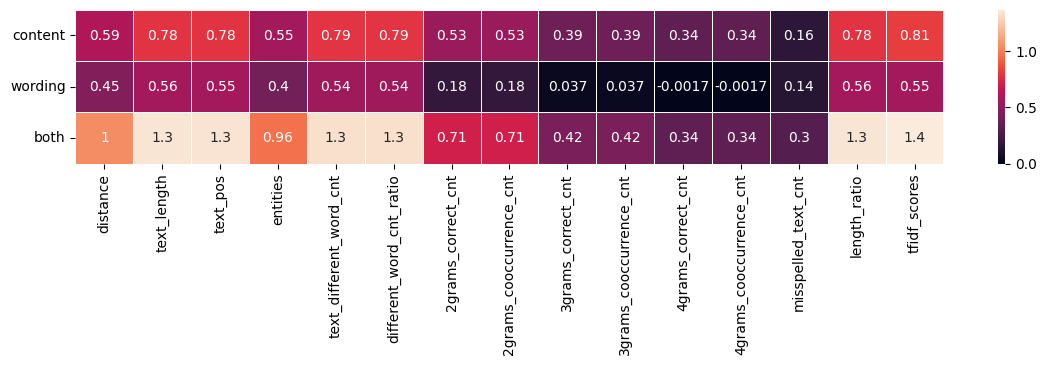

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
x_labels = content_corr.axes[0].tolist()
y_labels = ['content', 'wording', 'both']
fig, ax = plt.subplots(figsize=(14,2))
ax = sn.heatmap([content_corr[2:], wording_corr[2:], both_corr[2:]], xticklabels=x_labels[2:], yticklabels=y_labels, annot=True, linewidths=.5)
plt.show()

In [ ]:
training_data.to_csv('dataset.csv', index=False)

In [ ]:
!zip -r 'dataset.zip' 'dataset.csv' # download and save in github

  adding: dataset.csv (deflated 95%)
